######  Necessary library

In [52]:
import tensorflow as tf
import numpy as np
from pylab import rcParams
from numpy import linalg as LA
import matplotlib.pyplot as plt
from keras.datasets import fashion_mnist
from keras.utils import to_categorical
# Improve progress bar display
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
tf.enable_eager_execution()
tf.set_random_seed(1867)

In [53]:
#Batch_Size for training
batch_size = 64
#number of classes in fashion mnist datasets  
num_classes = 10
# no of epoch
epochs = 10

##### Load Data

In [54]:
#Loading data using load_data() API
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

#tf.data, the recommended API for building input pipelines in TensorFlow.
dataset_train = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_train/255, tf.float32),
    tf.cast(y_train, tf.int64)
)).shuffle(1000).batch(64)

dataset_test = tf.data.Dataset.from_tensor_slices((
    tf.cast(x_test/255, tf.float32),
    tf.cast(y_test, tf.int64)
)).batch(64)

##### Model

In [55]:
'''
    Implements the forward propagation for the model:
    LINEAR->RELU->LINEAR->RELU->LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX
'''
input_shape = x_train[1].shape
X_input = tf.keras.Input(input_shape)

X = tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False)(X_input)
X = tf.keras.layers.Dense(1000, activation=tf.nn.relu, use_bias=False)(X)
X = tf.keras.layers.Dense(500, activation=tf.nn.relu, use_bias=False)(X)
X = tf.keras.layers.Dense(200, activation=tf.nn.relu, use_bias=False)(X)
X = tf.keras.layers.Dense(num_classes, activation=tf.nn.relu,use_bias=False)(X)

fmnist_model=tf.keras.Model(inputs=X_input,name='fmnist_model',outputs=X)

##### Training  the model  using eager execution

In [56]:
# Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer
optimizer = tf.train.AdamOptimizer(learning_rate=0.0001)

"""
global_step refers to the number of batches seen by the graph. Every time a batch is provided,
the weights are updated in the direction that minimizes the loss.
global_step just keeps track of the number of batches seen so far.
"""
global_step = tf.train.get_or_create_global_step()

# For plotting the loss of the model 
training_losses = []
# For plotting the accuracy of the model 
training_accuracies = []

for epoch in range(epochs):
    #Loss function 
    epoch_loss_avg = tf.contrib.eager.metrics.Mean()
    #Metric for evalaution of the model 
    epoch_accuracy = tf.contrib.eager.metrics.Accuracy()
    for x, y in tqdm(dataset_train, total=round(len(x_train)/batch_size)):
        # For Calculating the graidents for the backpropagation
        with tf.GradientTape() as tape:
            outputs = model(x)
            loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, num_classes), outputs)
        grads = tape.gradient(loss, model.trainable_weights)
        optimizer.apply_gradients(zip(grads, model.trainable_weights), global_step)
        epoch_loss_avg(loss)
        epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
    
    training_losses.append(epoch_loss_avg.result())
    training_accuracies.append(epoch_accuracy.result())

Text(0,0.5,'Train Accuracy')

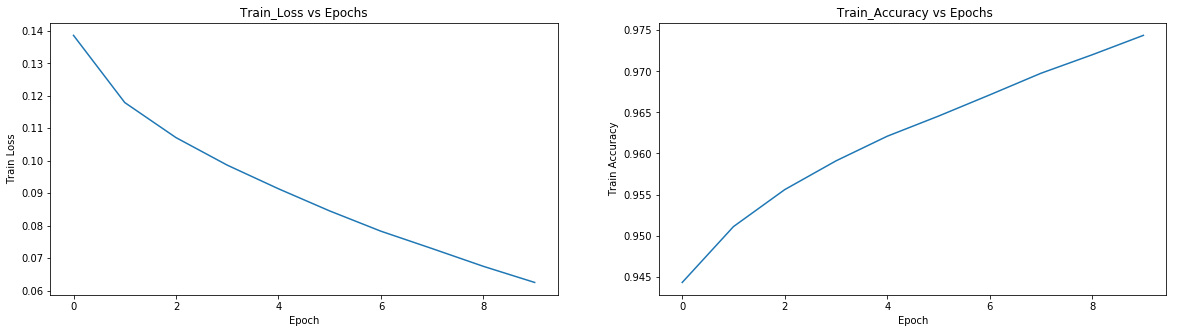

In [57]:
# Plot training curves
plt.figure(1, figsize=(20,5))
plt.subplot(121)
plt.plot(training_losses)
plt.title('Train_Loss vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Train Loss')

plt.subplot(122)
plt.plot(training_accuracies)
plt.title(' Train_Accuracy vs Epochs')
plt.xlabel('Epoch')
plt.ylabel('Train Accuracy')

In [58]:
def test_evaluate(model, dataset):
    """
    Method for evaluation test data
    
    Arguments:
    model -- tensorflow model
    dataset -- Data to evaluate 
    
    Returns:
    epoch_loss_avg --Test loss
    epoch_accuracy -- Test accuracy
    """
    #Loss 
    epoch_loss_avg = tf.contrib.eager.metrics.Mean()
    #Metric for evalaution of the model 
    epoch_accuracy = tf.contrib.eager.metrics.Accuracy()
    for x, y in dataset:
        outputs = model(x)
        loss = tf.losses.softmax_cross_entropy(tf.one_hot(y, 10), outputs)
        epoch_loss_avg(loss)
        epoch_accuracy(tf.argmax(outputs, axis=1, output_type=tf.int64), y)
        
    return epoch_loss_avg.result().numpy(), epoch_accuracy.result().numpy()

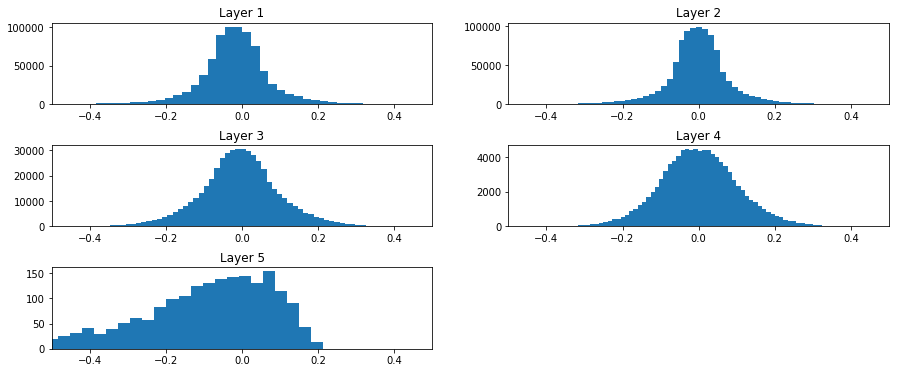

In [66]:
# Plot histogram of each layer's weights (for weight pruning)
plt.figure(1, figsize=(15,6))
plt.subplots_adjust(hspace=0.5)
for i, weights in enumerate(model.trainable_weights):
    plt.subplot(3,2,i+1)
    plt.title("Layer {}".format(i+1))
    plt.hist(weights.numpy().reshape(-1), bins=100)
    plt.xlim(-0.5, 0.5);

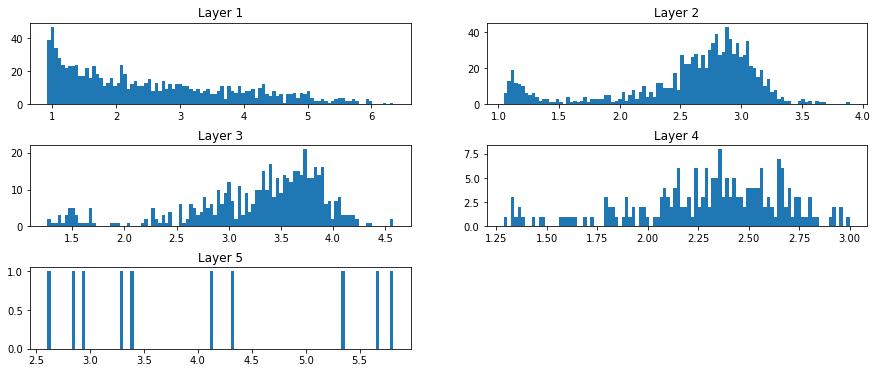

In [67]:
# Plot histogram of each layer's coloumn norms (for unit pruning)
plt.figure(2, figsize=(15,6))
plt.subplots_adjust(hspace=0.5)
for i, weights in enumerate(model.trainable_weights):
    column_norms = np.linalg.norm(weights.numpy(), ord=2, axis=0)
    plt.subplot(3,2,i+1)
    plt.title("Layer {}".format(i+1))
    plt.hist(column_norms, bins=100);

In [62]:
#Saving the model weights
model.save_weights('pre_trained.h5', save_format='h5')

#### Weight Pruning

In [60]:
def weight_prune(weight, k):
    '''
    Method to rank the individual weights in weight matrix W
    according to their magnitude (absolute value), and then set to zero the smallest
    k%.
    
    Arguments:
    weight -- weigths to prune
    k -- pruning percent
    
    Returns:
    weights  = pruned weigths
    '''
    weights = []
    weight_temp = weight
    weight_temp = np.absolute(weight_temp)
    weight_temp = np.sort(weight_temp, axis = None)
    threshold = weight_temp[int(k*weight_temp.size)] #Finding the threshold weight
    weight[(weight < threshold) & (weight > -threshold)] = 0 #Setting the lowest k% weights to 0
    weights.append(weight)

    return weights

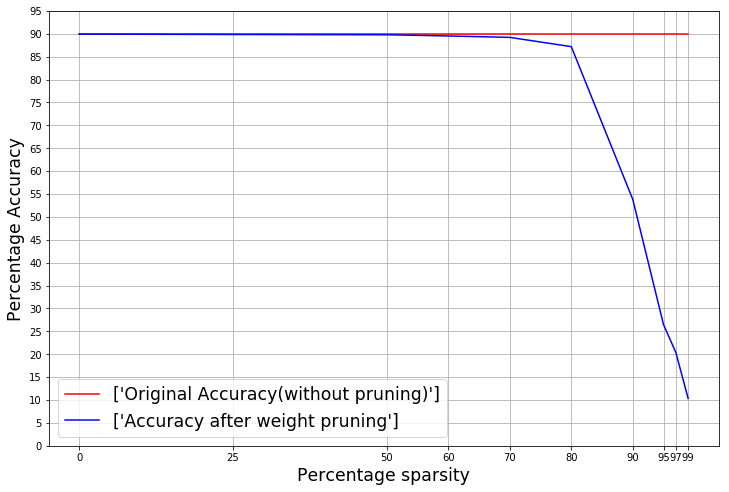

In [63]:
#Weight Pruning
accuracy_weight_pruning=[]
original_accuracy=[]
sparsity = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

for k2 in sparsity:
    k = k2*0.01
    for i in range(1,5):
        # get_weights get the  weights of the particular layer
        weight = model.layers[i].get_weights()[0]
        # set_ weights set assign prune to weights to particular layer
        model.layers[i].set_weights(weight_prune(weight, k))
    score, acc = test_evaluate(model, dataset_test)
    accuracy_weight_pruning.append(acc*100)
    model.load_weights('pre_trained.h5') #Reloading weights
    score, acc = test_evaluate(model, dataset_test)
    original_accuracy.append(acc*100)
    

    
rcParams['figure.figsize'] = 12, 8
plt.plot(sparsity,original_accuracy,'r', sparsity,accuracy_weight_pruning,'b')
plt.grid()
plt.legend([['Original Accuracy(without pruning)'],['Accuracy after weight pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Percentage sparsity',fontsize='xx-large')
plt.ylabel('Percentage Accuracy',fontsize='xx-large')
plt.xticks(sparsity)
plt.yticks(np.arange(0,100,5))
plt.show()

##### Unit/Neuron Pruning

In [61]:
def unit_prune(weight, k):
    '''
    Method to rank the columns of a weight matrix according
    to their L2-norm and delete the smallest k%.
    
    Arguments:
    weight -- weigths to prune
    k -- pruning percent 
    
    Returns:
    weights  = pruned weigths
    ''' 
    weights = []
    weight_temp = np.linalg.norm(weight, axis=0) #Finding norm of each column
    sorted = np.sort(weight_temp)
    threshold = sorted[int(k*sorted.size)] #Finding threshold norm
    j=0
    for i in weight_temp:
        if(i<threshold):
            weight[:, j] = 0 #set jth column in weight matrix to 0 because it's norm is less than that of threshold
        j=j+1
    weights.append(weight)
    return weights

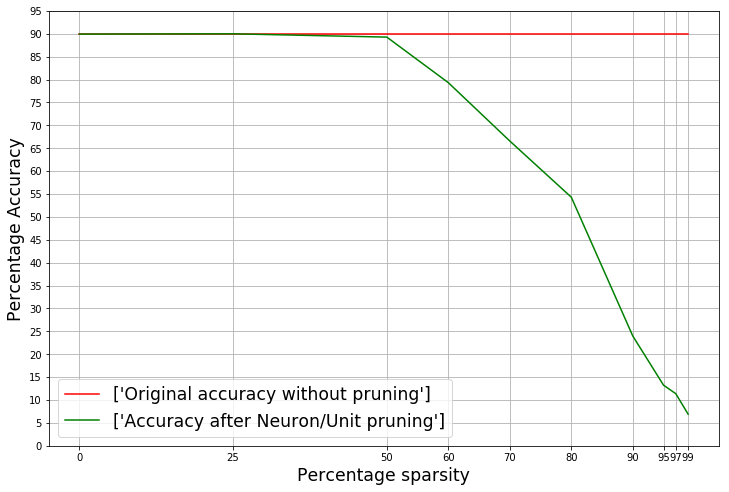

In [65]:
#Unit Pruning
accuracy_unit_pruning=[]
original_accuracy=[]

sparsity = [0, 25, 50, 60, 70, 80, 90, 95, 97, 99]

for k2 in sparsity:
    k = k2*0.01
    for i in range(1,5):
        # get_weights get the  weights of the particular layer
        weight = model.layers[i].get_weights()[0]
        # set_ weights set assign prune to weights to particular layer
        model.layers[i].set_weights(unit_prune(weight, k))
    score, acc = test_evaluate(model, dataset_test)
    accuracy_unit_pruning.append(acc*100)
    model.load_weights('pre_trained.h5') #Reloading weights
    score, acc = test_evaluate(model, dataset_test)
    original_accuracy.append(acc*100)

    
rcParams['figure.figsize'] = 12, 8
plt.plot(sparsity,original_accuracy,'r', sparsity,accuracy_unit_pruning,'g')
plt.grid()
plt.legend([['Original accuracy without pruning'],['Accuracy after Neuron/Unit pruning']],
           loc='lower left', fontsize='xx-large')
plt.xlabel('Percentage sparsity',fontsize='xx-large')
plt.ylabel('Percentage Accuracy',fontsize='xx-large')
plt.xticks(sparsity)
plt.yticks(np.arange(0,100,5))
plt.show()

## Conclusions

* we see that the weights of the model (barring those in the final layer) are normally distributed, with most of the weights being centered around 0. Thus when weight pruning, the vast majority of weights are of low magnitude and can be removed with minimal impact to performance. In contrast,histogram of each layer's coloumn norms shows that the column norms of the weights are far more spread out, and not centered around 0 (by definition of the L2 norm). If we view the individual weights in a column as being independent draws from the normal distribution for that layer (maybe not a valid assumption), then the L2 column norms would follow a chi-distribution (which seems in-line with the histograms actually). When pruning columns, it's unlikely that a column is filled with many high-magnitude weights; it's more common for there to be a mixture of low and high magnitude weights.


* As the sparsity increases from 0 to 50%, there is a very small decrease in accuracy. This means that at least half of the neurons in a neural network are redundant and do not contribute to accuracy at all (the number of redundant neurons is higher in case of neuron pruning as compared to weight pruning).


* In the Weight pruning method, even after pruning 70% of weights in each layer, the accuracy remains at 90%. We can say only 30%(approx. 715,800 out of 2,386,000 parameters) are contributing to the final output. This sparsity can be used to decrease network size and to increase performance.


* Neuron pruning shows a significantly faster drop in accuracy as compared to weight pruning. The reason for this is that for a sparsity of k%, k% of the weights become zero in case of weight pruning, whereas in neuron pruning k% of the neurons are deleted in each layer which leads to the deletion of lot more connections as compared to weight pruning with same sparsity.


* The presence of an excess of redundant neurons provides scope for decreasing the size of neural network while maintaining the same accuracy.